## MARN5895(RC) Final Project: MUR SST Demo 
#### Created by Mackenzie Blanusa and Shannon Jordan, Fall 2021

### Import Packages 

In [1]:
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
warnings.simplefilter('ignore') # filter some warning messages
xr.set_options(display_style="html")  #display dataset nicely 
import cmocean as cm

# cartopy 
import cartopy.crs as ccrs       # ccrs contains information about projections
import cartopy                   # contains all other cartopy functions/classes/methods
import cartopy.feature as cfeature

### Step 1. Set up Dask for lazy/parallel computing 

In [2]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster(worker_memory=8)  # specify worker memory, max = 8
cluster.adapt(minimum=1, maximum=60)  # specify how many workers 
client = Client(cluster)
cluster

click on the above link to access the Dask dashboard

### Step 2. Load the MUR SST Dataset

2.1 Load the MUR SST dataset from AWS 

2.2 Mask out erroneous data near poles 

In [3]:
# 2.1 load MUR SST dataset from AWS
%time 
AWS_url = 'https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1' # URl to amazon s3 bucket 
ds_sst = xr.open_zarr(AWS_url, consolidated=True)
ds_sst

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Note that the MUR SST dataset from AWS only has data available from 2002-Jan 2020, where as the dataset from PODAAC has data availble to present day. 

##### There are some erroneous SSTs near land at the poles so we will mask those out based on sea-ice fraction 

The erroneous SSTs near land stem from the ice mask used by the dataset. The ice mask is based on satellite passive microwave estimates of sea ice and these estimates are not available near land. 

In [4]:
sst = ds_sst['analysed_sst']

cond = (ds_sst.mask==1) & ((ds_sst.sea_ice_fraction<.15) | np.isnan(ds_sst.sea_ice_fraction)) 
 

sst_masked = ds_sst['analysed_sst'].where(cond)

sst_masked

,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,1276113 Tasks,141790 Chunks
Type,float32,numpy.ndarray


### Step 3. Resample and group the data to create daily, monthly, yearly, and seasonal climatologies and anomalies  

Utilize xarray's resample and groupby functions

In [5]:
%%time
#create a daily climatology and anomaly

daily_clima = sst_masked.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

daily_anom = sst_masked.groupby('time.dayofyear')-daily_clima  #take out annual mean to remove trends

#create a monthly dataset, climatology, and anomaly

sst_monthly = sst_masked.resample(time='1MS').mean('time',keep_attrs=True,skipna=False)

monthly_clima = sst_monthly.groupby('time.month').mean('time',keep_attrs=True,skipna=False)

monthly_anom = sst_monthly.groupby('time.month')-monthly_clima  #take out annual mean to remove trends

# create a yearly dataset, climatology, and anomaly 

sst_yearly = sst_masked.resample(time='1Y').mean('time',keep_attrs=True,skipna=False)

yearly_clima = sst_yearly.groupby('time.year').mean('time',keep_attrs=True,skipna=False)

yearly_anom = sst_yearly.groupby('time.year')-yearly_clima #take out annual mean to remove trends 


CPU times: user 14.2 s, sys: 474 ms, total: 14.7 s
Wall time: 14.7 s


Xarray's groupby function also has a 'time.season' option to group the data seasonally (DJF,MAM,JJA,SON). However, xarray does not have a resample by season option, so when an anomaly is calculated using the above methods the data does not get grouped seasonally anymore. 

As a work around, we can resample seasonally by resampling every 3 months - but we need to make sure the time starts at one of the first months in a season (i.e. Dec, Mar, Jun, or Sept). Then we can extract all the seasons by indexing the dataset by each months position.

In [6]:
# resample every 3 months 
sst_seasonal = sst_monthly.resample(time='3M').mean()

In [7]:
# The data is now averaged over every three months 
# Months 06,09,12,03 are the seasons JJA,SON,DJF,MAM
sst_seasonal

,Array,Chunk
Bytes,186.61 GB,25.91 MB
Shape,"(72, 17999, 36000)","(1, 1799, 3600)"
Count,1752853 Tasks,7920 Chunks
Type,float32,numpy.ndarray


In [8]:
# extract the seasons from the data set 
JJA = sst_seasonal[0::4] # here we are selecting every 4th position starting at position 0 
SON = sst_seasonal[1::4]
DJF = sst_seasonal[2::4] # selecting every 4th position starting at position 2 
MAM = sst_seasonal[3::4]

In [9]:
# calculate seasonal climas and anoms 

# JJA_clima = JJA.mean(dim='time')
# JJA_anom = JJA - JJA_clima 

# SON_clima = SON.mean(dim='time')
# SON_anom = SON - SON_clima 

# DJF_clima = DJF.mean(dim='time')
# DJF_anom = DJF - DJF_clima 

# MAM_clima = MAM.mean(dim='time')
# MAM_anom = MAM - MAM_clima 

seasons=['JJA','SON','DJF','MAM']       # This for loop does the above operations 
for season in seasons:
    exec(season+ '_clima = '+season+'.mean(dim="time")')
    exec(season+ '_anom = '+season + '-' + season + '_clima')

### Step 4. Make global plots using xarray coarsen 

We must coarsen the resolution in order to plot a global image. The scale is 1km x 1km, which corresponds to a resolution of 0.01deg x 0.01deg. Extracting a single day of data at this resolution is still ~2.5 GB of data which is too much. We will coarsen the resolution by a factor of 10. 

In [10]:
# select a day from the dataset
summerday = sst_masked.sel(time='2019-07-30')

In [11]:
summerday

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
dask.array<getitem, shape=(1, 17999, 36000), dtype=float32, chunksize=(1, 1799, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2019-07-30T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [12]:
# coarsen the resolution by a factor of 10
summerday = summerday.coarsen(lat=10,lon=10,boundary='trim').mean()

In [13]:
# note the changes in lat/lon and the size of the data
summerday

<xarray.DataArray (time: 1, lat: 1799, lon: 3600)>
dask.array<mean_agg-aggregate, shape=(1, 1799, 3600), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.95 -89.84 -89.75 -89.64 ... 89.66 89.75 89.86
  * lon      (lon) float32 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 2019-07-30T09:00:00

In [14]:
# convert deg K to deg C 
summerday = summerday - 273.15

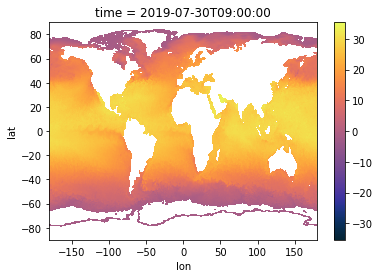

In [15]:
summerday.plot(cmap='cmo.thermal')

### Step 5: Slice the dataset for a desired region (western tropical Atlantic) and make some plots 

In [16]:
# slicing the global datasets, climatologies, and anomalies calculated earlier

daily_sst = sst_masked.sel(lon=slice(-62,-48),lat=slice(4,14))
daily_clima = daily_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
daily_anom = daily_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_sst = sst_monthly.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_clima = monthly_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_anom = monthly_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_sst = sst_yearly.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_clima = yearly_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_anom = yearly_anom.sel(lon=slice(-62,-48),lat=slice(4,14))

#seasonal data 
JJA = JJA.sel(lon=slice(-62,-48),lat=slice(4,14))
JJA_clima = JJA_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
JJA_anom = JJA_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
SON = SON.sel(lon=slice(-62,-48),lat=slice(4,14))
SON_clima = SON_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
SON_anom = SON_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF = DJF.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF_clima = DJF_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF_anom = DJF_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM = MAM.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM_clima = MAM_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM_anom = MAM_anom.sel(lon=slice(-62,-48),lat=slice(4,14))

In [46]:
# taking a spatial average of the daily, monthly, and yearly datasets and load them in 
daily_spatial = daily_sst.mean(dim=('lon','lat')).load()
monthly_spatial = monthly_sst.mean(dim=('lon','lat')).load()
yearly_spatial = yearly_sst.mean(dim=('lon','lat')).load()

In [47]:
# Convert deg K to deg C 
daily_spatial = daily_spatial - 273.15
monthly_spatial = monthly_spatial - 273.15
yearly_spatial = yearly_spatial - 273.15

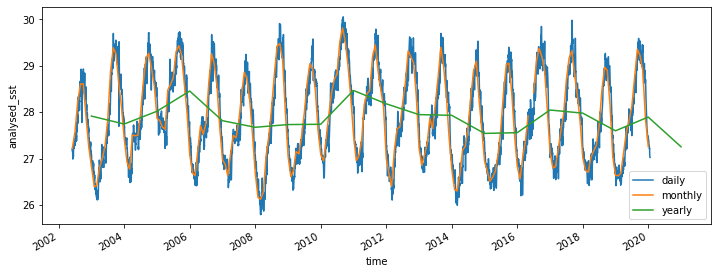

In [48]:
# plot the spatially averaged SST data over time 
fig = plt.figure(figsize=(12,4))
daily_spatial.plot(label='daily')
monthly_spatial.plot(label='monthly')
yearly_spatial.plot(label='yearly')
plt.legend()

In [20]:
# load in seasonal data and convert deg K to deg C 
seasons = ['JJA','DJF','MAM','SON']
for season in seasons:
    exec(season+'.load()')
    exec(season +'='+season+'-273.15')

In [21]:
# load in seasonal climatology data and convert deg K to deg C 
seasons = ['JJA','DJF','MAM','SON']
for season in seasons:
    exec(season+'_clima.load()')
    exec(season +'_clima ='+season+'_clima -273.15')

In [30]:
MAM_clima.min()

<xarray.DataArray 'analysed_sst' ()>
array(25.88830566)

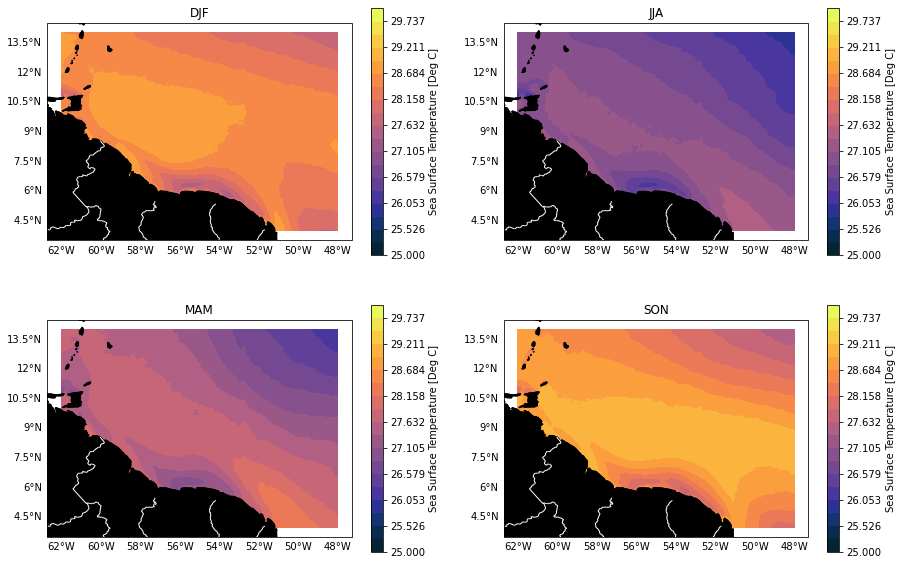

In [34]:
# Seasonal climatology  plots using cartopy 

kw = {'cmap':'cmo.thermal','transform':ccrs.PlateCarree(),'vmin':25,'vmax':30,'levels':20}
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(15,10),constrained_layout=False,
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

DJF_clima.plot(ax=axs[0],**kw,zorder=0,cbar_kwargs={'label':'Sea Surface Temperature [Deg C]'})
JJA_clima.plot(ax=axs[2],**kw,zorder=0,cbar_kwargs={'label':'Sea Surface Temperature [Deg C]'})
MAM_clima.plot(ax=axs[1],**kw,zorder=0,cbar_kwargs={'label':'Sea Surface Temperature [Deg C]'})
SON_clima.plot(ax=axs[3],**kw,zorder=0,cbar_kwargs={'label':'Sea Surface Temperature [Deg C]'})

axs[0].set_title('DJF')
axs[1].set_title('JJA')
axs[2].set_title('MAM')
axs[3].set_title('SON')

for i in [0,1,2,3]:      # looping through axs to give all subplots the same features 
    axs[i].coastlines()
    axs[i].add_feature(cartopy.feature.BORDERS,color='w',zorder=2)
    axs[i].add_feature(cartopy.feature.LAND,color='k',zorder=1)
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(),
             draw_labels=True,
             linewidth=1,
             color='gray',
             alpha=0,
             linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

In [35]:
# take a spatial average for each season to look at time series 
JJA_spatial = JJA.mean(dim=('lat','lon'))
SON_spatial = SON.mean(dim=('lat','lon'))
DJF_spatial = DJF.mean(dim=('lat','lon'))
MAM_spatial = MAM.mean(dim=('lat','lon'))

Text(0.5, 1.0, 'SON')

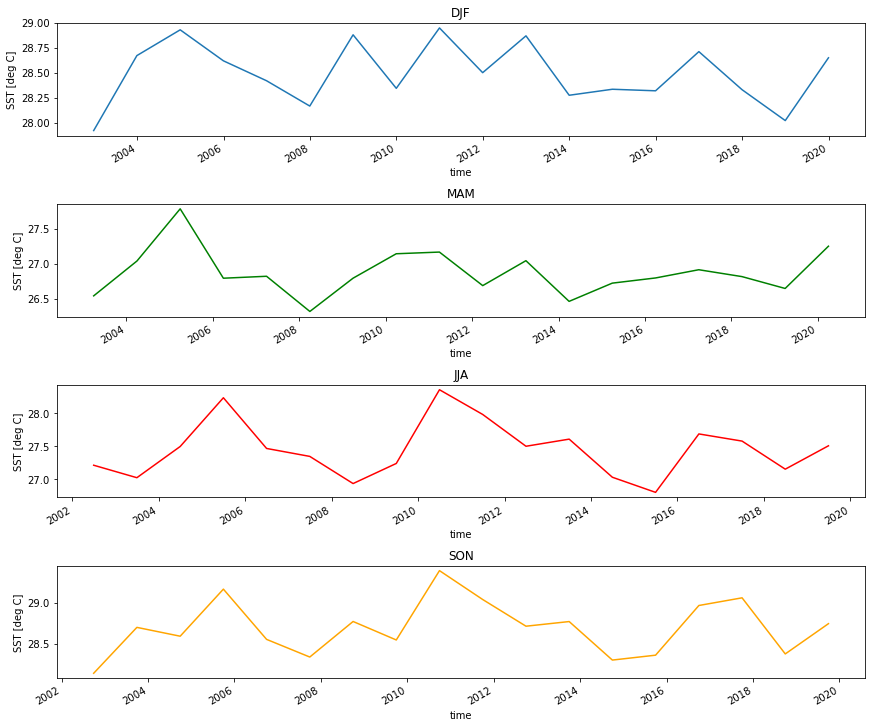

In [40]:
# time series plots of seasonal average SST 
fig, ax = plt.subplots(ncols=1, nrows=4, constrained_layout=True, figsize=(12,10))
JJA_spatial.plot(label='JJA',ax=ax[2],color='r')
SON_spatial.plot(label='SON',ax=ax[3],color='orange')
DJF_spatial.plot(label='DJF',ax=ax[0])
MAM_spatial.plot(label='MAM',ax=ax[1],color='g')

for i in [0,1,2,3]:
    ax[i].set_ylabel('SST [deg C]')

ax[0].set_title('DJF')
ax[1].set_title('MAM')
ax[2].set_title('JJA')
ax[3].set_title('SON')

### Step 6. Calculate some statistics and make a table using Pandas 

In [49]:
def get_stats(X):
    """This function calculate the mean, min, and max of a data array,
       rounded to two decimal places
       
       Inputs: X
       X is a data array 
       
       Returns: mean, min, and max 
       """
    return [np.round(np.mean(X).values,2),np.round(np.min(X).values,2),np.round(np.max(X).values,2)]

In [50]:
# Calculate stats for seasonally averaged data and yearly averaged data 
JJA_spatial_stats = get_stats(JJA_spatial)
SON_spatial_stats = get_stats(SON_spatial)
MAM_spatial_stats = get_stats(MAM_spatial)
DJF_spatial_stats = get_stats(DJF_spatial)
yearly_spatial_stats = get_stats(yearly_spatial)

In [51]:
# Extract the years the max and min SST values occur 
time_range=['JJA','SON','DJF','MAM','yearly']
for time in time_range:
    exec(time+'_dates = [str('+time+'_spatial[np.argmin('+time+'_spatial.values)].time.values)[:4],'
             'str('+time+'_spatial[np.argmax('+time+'_spatial.values)].time.values)[:4]]')

In [52]:
# create arrays of the stats to be used in the Pandas dataframe 
means = [DJF_spatial_stats[0],MAM_spatial_stats[0],JJA_spatial_stats[0],SON_spatial_stats[0],
        yearly_spatial_stats[0]]
mins = [DJF_spatial_stats[1],MAM_spatial_stats[1],JJA_spatial_stats[1],SON_spatial_stats[1],
       yearly_spatial_stats[1]]
min_year = [DJF_dates[0],MAM_dates[0],JJA_dates[0],SON_dates[0],
       yearly_dates[0]]
max_year = [DJF_dates[1],MAM_dates[1],JJA_dates[1],SON_dates[1],
       yearly_dates[1]]
maxs = [DJF_spatial_stats[2],MAM_spatial_stats[2],JJA_spatial_stats[2],SON_spatial_stats[2],
       yearly_spatial_stats[2]]
times = ['DJF','MAM','JJA','SON','Year']

In [53]:
# Create a pandas dataframe with the stats 
df = pd.DataFrame(data=([times,means,mins,min_year,maxs,max_year])) #define data
df = df.T  # transpose table
df = df.rename(columns={0:'Time Frame',1:'SST Mean',2:'SST Min',3:'Min Year',
                        4:'SST Max',5:'Max Year'})  # rename columns 
df

,Time Frame,SST Mean,SST Min,Min Year,SST Max,Max Year
0,DJF,28.5,27.92,2002,28.95,2010
1,MAM,26.879999,26.32,2008,27.79,2005
2,JJA,27.459999,26.8,2015,28.36,2010
3,SON,28.690001,28.14,2002,29.39,2010
4,Year,27.870001,27.25,2020,28.47,2010


#### Acknowledement: Chelle Gentemann's OSM 2020 tutorial
https://github.com/pangeo-gallery/osm2020tutorial